In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [3]:
random_seed = 42

In [4]:
from stop_words import get_stop_words
stop_words = get_stop_words('ru')
for word in ['свой', 'р', 'г', 'назир', 'назиров', 'б']:
    stop_words.append(word)

In [63]:
documents = []
filenames = []

for d, dirs, files in os.walk('lemma_texts'):
    for f in files:
        text = open(os.path.join('.', d, f), 'r', encoding='utf-8').read()
        documents.append(text.replace('\n', ' ').replace('?', ''))
        filenames.append(d.replace('lemma_texts/', '') + os.sep + f)

# K-means and visualization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stop_words,
                                 use_idf=True, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

tfidf_matrix.shape

(65, 3896)


In [13]:
# list of the features used in the tf-idf matrix
terms = tfidf_vectorizer.get_feature_names()

In [16]:
# the cosine similarity of each document
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [17]:
from sklearn.cluster import KMeans

In [18]:
num_clusters = 4
# diary, dostoevsky, literature, myth

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [22]:
from sklearn.externals import joblib

In [83]:
# pickle the model
_ = joblib.dump(km,  'doc_cluster.pkl')

In [24]:
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [65]:
nazirov = { 'title': filenames, 'text': documents, 'cluster': clusters}

frame = pd.DataFrame(nazirov, index = [clusters] , columns = ['title', 'cluster'])

In [26]:
frame['cluster'].value_counts()

0    26
1    17
2    13
3     9
Name: cluster, dtype: int64

In [68]:
print("Top terms per cluster:")
print()
# sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: 
        print(' %s' % terms[ind], end='')
    print() 
    print() 
    
    print("Cluster %d titles:\n" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='\n')
    print()
    print()

Top terms per cluster:

Cluster 0 words: раскольников чехов читатель князь пушкин преступление

Cluster 0 titles:
 diary/2016_2_02_diary_1950_1951_2.txt,
 diary/2016_2_04_diary_1957_4.txt,
 diary/2016_3_04_diary_1964_2.txt,
 diary/2016_2_03_diary_1956_na16.txt,
 literature/2013_1_95-98_war-n-peace_2016_4_03_friend_hugo-flaubert_nazirov-chexovcontr.txt,
 literature/2014_1_9-66_freid_2.txt,
 literature/effect_1.txt,
 literature/effect_3.txt,
 literature/2017_1_2_homestead_3.txt,
 literature/2017_1_2_homestead_4.txt,
 myth/Genezis_i_puti_razvitija_mifologicheskih_sjuzhetov_Istoki_sjuzheta_Kashheeva_smert_v_jajce_Istoricheskie_korni_evgemerizma,
 myth/Stanovlenie_mifov_i_ih_istoricheskaja_zhizn_1,
 myth/ditya_Dobyvanie_volshebnogo_mecha_evolution_Hrustalnyj_grob,
 dostoevsky/nazirov-book_2.txt,
 dostoevsky/2013_2_6-83_besy_2.txt,
 dostoevsky/nazirov-unizhennye_nazirov-verxovensky.txt,
 dostoevsky/readers_problem.txt,
 dostoevsky/nazirov-book_3.txt,
 dostoevsky/2013_2_6-83_besy_3.txt,
 dost

In [69]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=random_seed)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [79]:
cluster_colors = {0: '#1b9e77', 1: 'black', 2: 'b', 3: 'r'}

# in accordance with the top cluster words
cluster_names = {0: 'dostoevsky', 
                 1: 'myth', 
                 2: 'diary', 
                 3: 'literature'}

In [73]:
# rename filenames in the real cluster names 
cluster_filenames = [name.split(os.sep)[0] for name in filenames]

/home/socur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


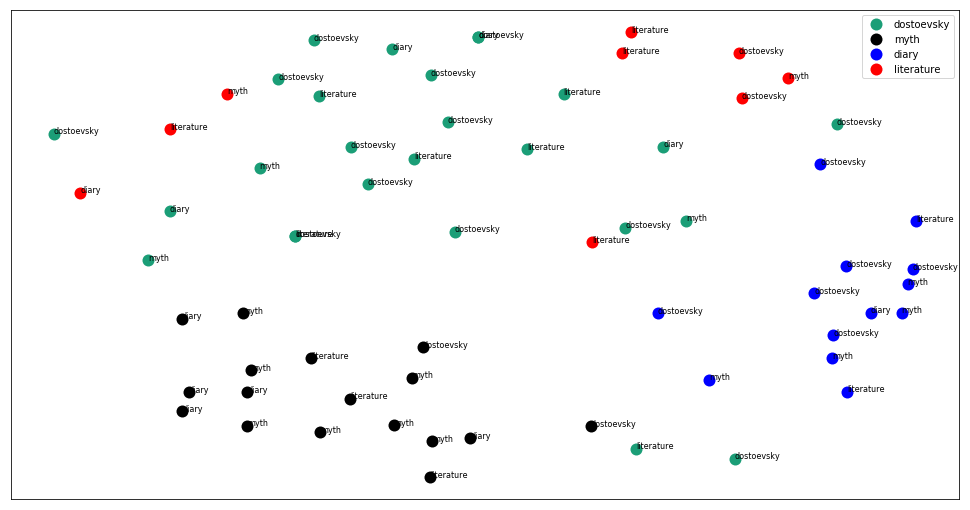

In [80]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=cluster_filenames)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  
    
_ = plt.show() #show the plot

In [81]:
plt.close()

# Ward and visualization

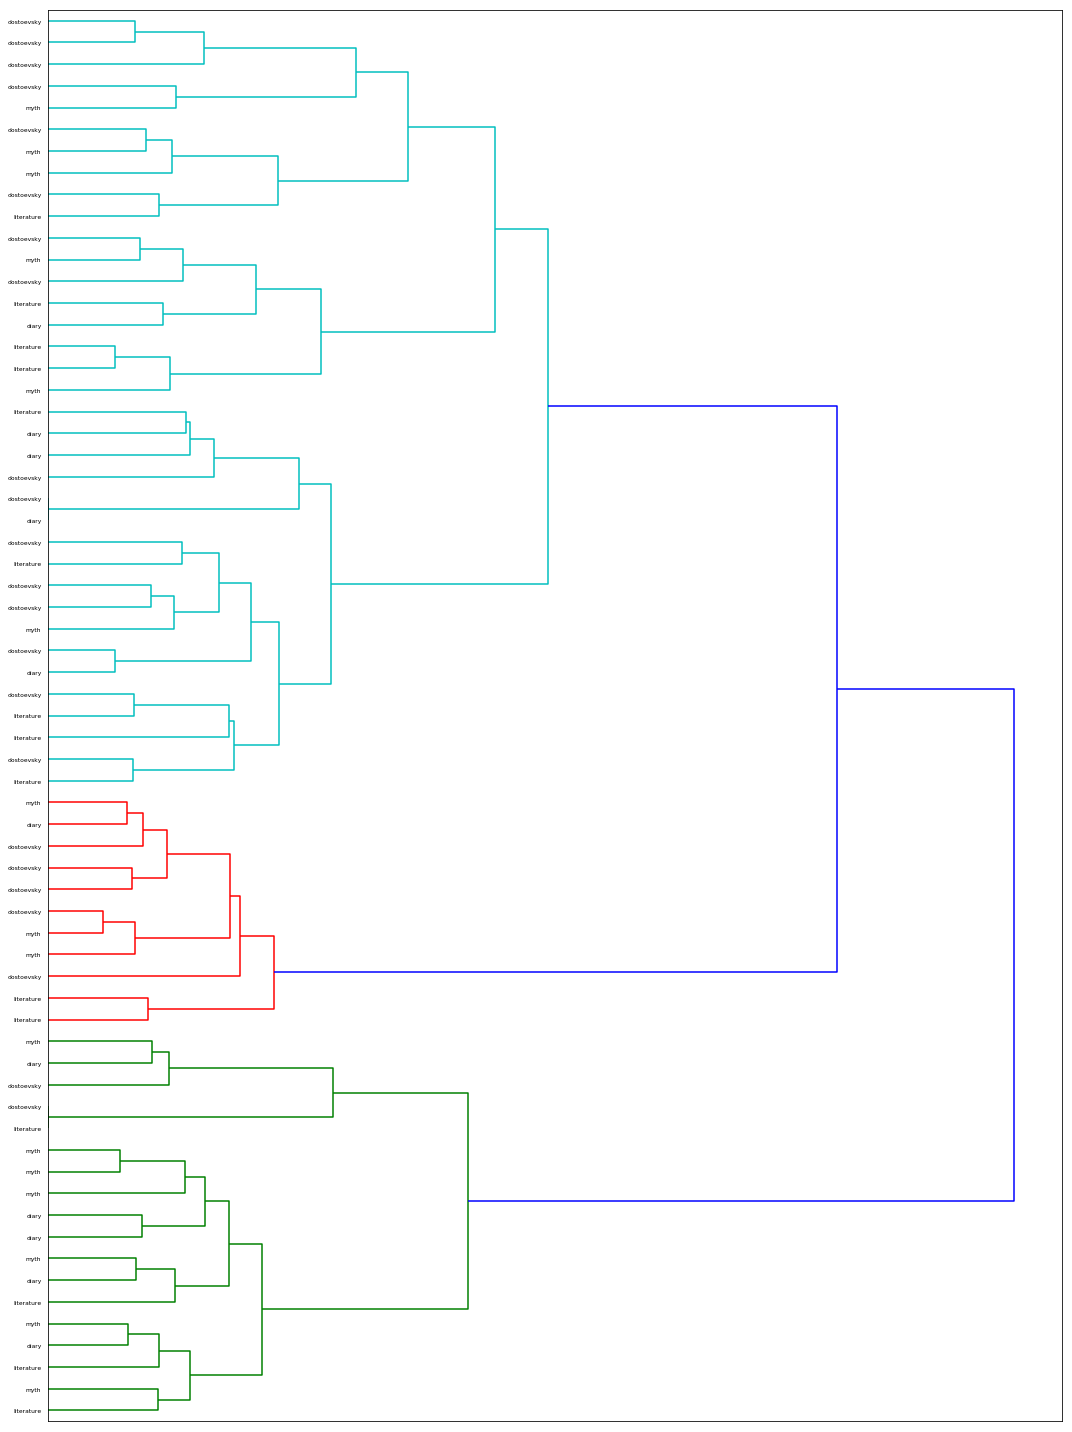

In [82]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) # define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=cluster_filenames);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#plt.savefig('ward_clusters.png', dpi=200) 